In [ ]:
# This code will attempt to subtract off a PSF
# From a galaxy with a known AGN
# 205 - 1 is a good example of this
# I am trying to make a version of it that takes up less space on the SC (fully convolved etc)


In [11]:
# My new idea is to use one spaxel, an also to use a stellar template if necessary.
import pyfits
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

(1358, 2846)


(2846, 67, 67)


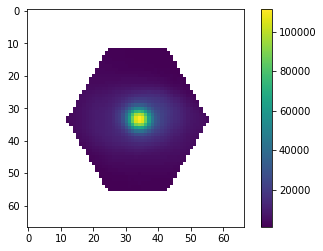

In [22]:
# The better way to do this is to construct a full 3D cube and work from there
small = pyfits.open('small_cube_alt_shape_fg3_m12_205_0.fits')
print(np.shape(small[0].data))

summed_specs = np.sum(small[0].data, axis=0)
plt.imshow(ma.masked_where(summed_specs==0,summed_specs))
plt.colorbar()
plt.show()

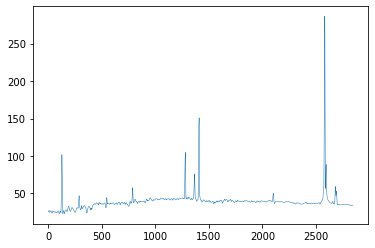

In [24]:
# The first step is to determine the brightest spaxel
coords = np.argwhere(summed_specs.max() == summed_specs)
plt.clf()
plt.plot(small[0].data[:,coords[0][0],coords[0][1]], label='Simulated Spectrum', lw=0.5)
plt.show()

In [27]:
# Use the OG mcrx file to get the wavelength array
mcrx = pyfits.open('mcrx_205_agnx0.fits')
manga_wave = np.load('manga_wavelengths_AA.npy')

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

Ang=np.array([x[0]*10**(10) for x in mcrx[5].data])
#so I think this is in air wavelengths, we need to convert to vacuum                                                                             
s = 10**4/Ang
n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.000159740894897 / (38.92568793293 - s**2)
Ang_vac = Ang*n
Ang = Ang_vac

new_Ang=[]
for p in range(10*len(Ang)):
    if p==0:
        starting_lambda=Ang[0]
    else:
        starting_lambda=starting_lambda+starting_lambda/2000
    new_Ang.append(starting_lambda)
    if starting_lambda > Ang[-1]:
        break

min_index=np.where(new_Ang==find_nearest(new_Ang,Ang[0]))[0][0]+1
max_index=np.where(new_Ang==find_nearest(new_Ang,Ang[-1]))[0][0]-1
new_Ang_wave=new_Ang[min_index:max_index-1]

min_index=np.where(manga_wave==find_nearest(manga_wave,new_Ang_wave[0]))[0][0]+1
max_index=np.where(manga_wave==find_nearest(manga_wave,new_Ang_wave[-1]))[0][0]-1
cut_manga_wave=manga_wave[min_index:max_index-1]

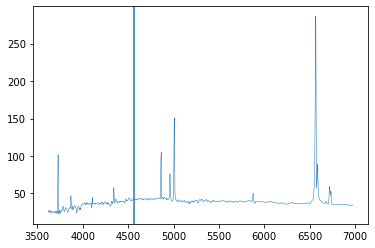

coordinates of center 33 34 value 111337.5705866401


In [113]:
# The first step is to determine the brightest spaxel
coords = np.argwhere(summed_specs.max() == summed_specs)
plt.clf()
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]], label='Simulated Spectrum', lw=0.5)
plt.axvline(x=cut_manga_wave[1000])
plt.show()

print('coordinates of center', coords[0][0],coords[0][1], 'value', np.sum(small[0].data[:,coords[0][0],coords[0][1]], axis=0))

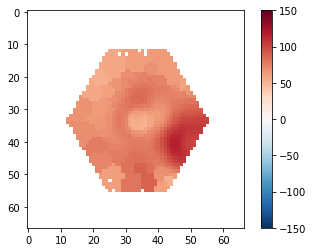

In [34]:
# The next step is to attempt to fit this with ppxf to show that it fails ...
# Alternately, you could just read the velocity cube for comparison

vel_maps = pyfits.open('vel_maps/stellar_kinematics_SCATTER_emline_fg3_m12_205_1.fits')
vel_2d = ma.masked_where(vel_maps[1].data==0, vel_maps[1].data)
plt.imshow(vel_2d, vmin=-150, vmax=150, cmap='RdBu_r')
plt.colorbar()
plt.show()

# So the problem here is that the AGN light is contaminating the entire extent of the galaxy.

(2846,)


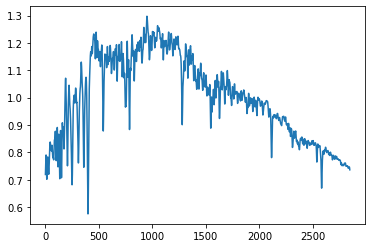

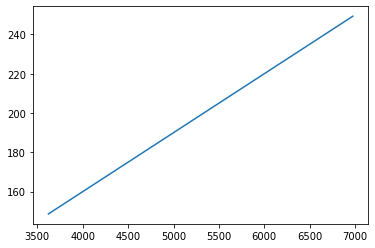

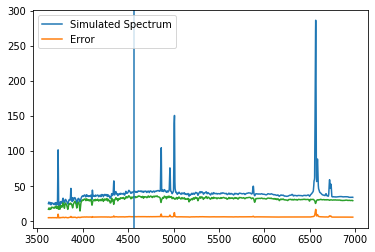

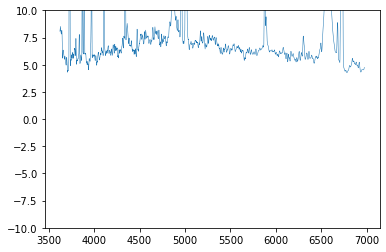

In [253]:
# The first step is to subtract off the stellar continuum in order to determine the shape of the
# contamination from the AGN at the center of the galaxy.

stellar_flux = np.load('model_flux_fg3_m12_205_0.npy', allow_pickle=True)
print(np.shape(stellar_flux))
plt.plot(stellar_flux/np.median(stellar_flux))
plt.show()

m_guess=0.03
b_guess=40
fxn = cut_manga_wave*m_guess+b_guess

plt.clf()
plt.plot(cut_manga_wave, fxn)
plt.show()

plt.clf()
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]], label='Simulated Spectrum')
plt.plot(cut_manga_wave, np.sqrt(small[0].data[:,coords[0][0],coords[0][1]]), label='Error')

plt.plot(cut_manga_wave, stellar_flux*fxn)
plt.axvline(x=cut_manga_wave[1000])
plt.legend()
#plt.ylim([0,50])
plt.show()

plt.clf()
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]]-stellar_flux*fxn, label='Simulated Spectrum', lw=0.5)
plt.ylim([-10,10])
plt.show()



In [ ]:
# Do a quick chi-squared fitting to determine what the multiple is to best fit the continuum
# Maybe you can do a polynomial fitting?

# So this would be like multiplying the (normalized) continuum function 
import emcee
def log_likelihood(theta, x, y, stellar, yerr):
    m, b = theta
    model = (m * x + b)*stellar
    sigma2 = yerr**2 + model**2
    return -0.5*np.sum((y-model)**2)#/sigma2 + np.log(sigma2))
def log_probability(theta, x, y, stellar, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, stellar, yerr)
def log_prior(theta):
    m, b = theta
    if -0.1 < m < 0.1:
        return 0.0
    return -np.inf

m_ml = 0.03
b_ml = 70
#m_guess=0.05
#b_guess=1
pos =  [m_ml, b_ml]+ 1e-2*np.random.randn(32, 2)
nwalkers, ndim = pos.shape
print(nwalkers, ndim)

#nwalkers = 100
#ndim = 2
x = cut_manga_wave
y = small[0].data[:,coords[0][0],coords[0][1]]
yerr = 0.1*small[0].data[:,coords[0][0],coords[0][1]]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, stellar_flux, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 9/5000 [00:00<01:00, 81.94it/s]

32 2


  9%|▉         | 441/5000 [00:05<00:53, 85.59it/s]

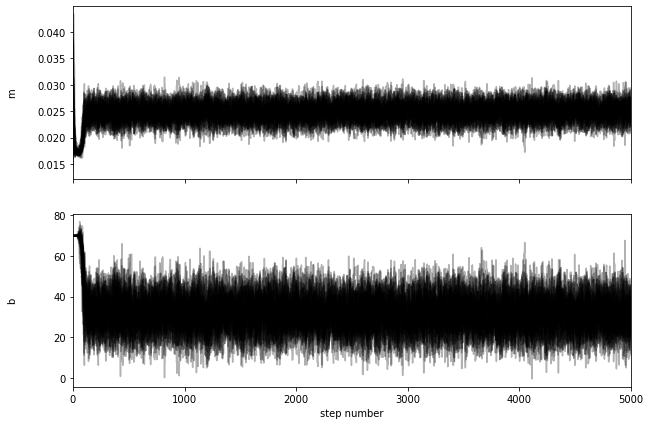

In [280]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

<IPython.core.display.Math object>

<IPython.core.display.Math object>

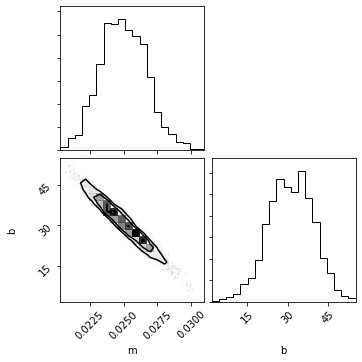

In [281]:
import corner
#tau = sampler.get_autocorr_time()
#print(tau)
flat_samples = sampler.get_chain(discard=2000, thin=100, flat=True)
fig = corner.corner(flat_samples, labels=labels);#, truths=[m_true, b_true, np.log(f_true)]);

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    



(100, 2846)


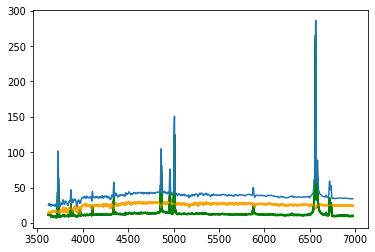

In [282]:
inds = np.random.randint(len(flat_samples), size=100)
model=[]
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, small[0].data[:,coords[0][0],coords[0][1]]-stellar_flux*np.dot(np.vander(x, 2), sample[:2]), "g", alpha=0.1)
    plt.plot(x, stellar_flux*np.dot(np.vander(x, 2), sample[:2]), "orange", alpha=0.1)
    model.append(stellar_flux*np.dot(np.vander(x, 2), sample[:2]))
    
plt.plot(x, y);
print(np.shape(model))
#plt.plot(x, np.sum(model, axis=0)/100, color='red');
#plt.ylim([0,50]);

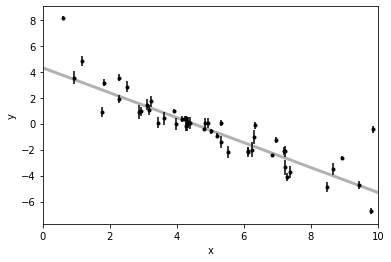

In [151]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


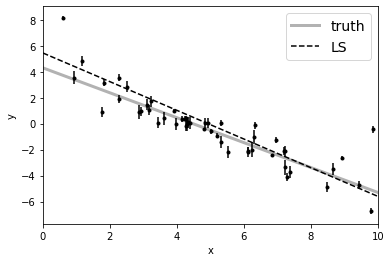

In [152]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

()
Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454
(3,)
(3,)


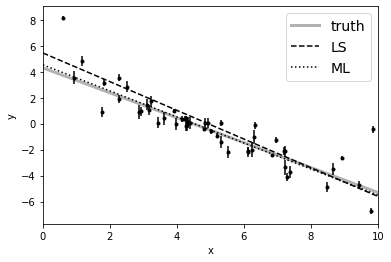

In [158]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))
from scipy.optimize import minimize
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x
print(np.shape(soln))

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");
pos = soln.x + 1e-4*np.random.randn(32, 3)
print(np.shape(soln.x))
rand_array = [3,2,1]
print(np.shape(rand_array))

2.1231422505307855


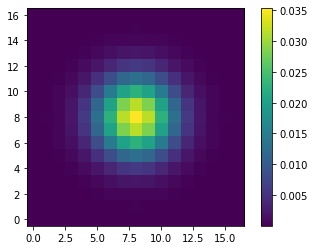

In [115]:
# Then, spread the light out according to the brightness of the PSF at that location.
from astropy.cosmology import WMAP9 as cosmo
from astropy.convolution import Gaussian2DKernel
import matplotlib

CAMERA0=mcrx[25+view]#25  
pixelscale=CAMERA0.header['CD1_1']
sigma = 2.5/2.355 #seeing is 2.5"
# the spaxels are spaced by 0.5", so sigma is 5 pixels

kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)

kernel_sigma_pix = 5/2.355
#(sigma*(kpc_arcmin.value/60))/pixelscale                                                         

print(kernel_sigma_pix)
                                                                                                                

gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)                                                             
plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
plt.colorbar()
plt.show()

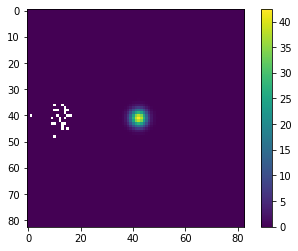

(2846, 83, 83)


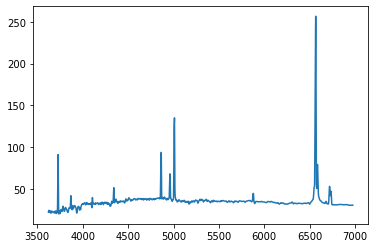

In [126]:
# Multiplication technique, first convolve so that the kernel is the proper size at one wavelength channel
empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))

brightest_spax = small[0].data[:,coords[0][0],coords[0][1]]

empty_gal[:,coords[0][0], coords[0][1]] = brightest_spax

conv = signal.fftconvolve(gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array), empty_gal[1000,:,:])#kernel was gaussian_3D_kernel                             

plt.imshow(ma.masked_where(conv==0, conv))
plt.colorbar()
plt.show()

# Repeat this at each individual wavelength so that you have your model AGN
AGN_mod = np.zeros((np.shape(small[0].data)[0], np.shape(conv)[1], np.shape(conv)[1]))
# It is okay that it has larger dimensions

for j in range(len(cut_manga_wave)):
    AGN_mod[j,:,:] = signal.fftconvolve(gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array), empty_gal[j,:,:])#kernel was gaussian_3D_kernel                             

                   
print(np.shape(AGN_mod))
plt.clf()
plt.plot(cut_manga_wave, AGN_mod[:,42,42])
plt.show()

In [ ]:
# Now trying to think 

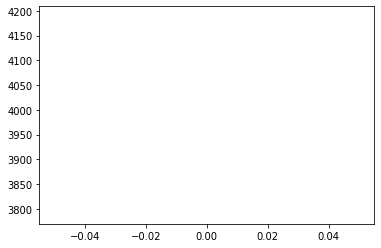

2846
gaussian_3D_kernel (2846, 17, 17)
(1, 17, 17)
(1, 17, 17) (2846,)


<Figure size 432x288 with 0 Axes>

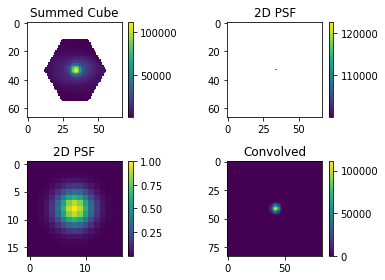

In [109]:
# How to apply this to the correct size?
from scipy import signal

# Create a new map masking everything but the brightest spaxel
new = ma.masked_where(summed_specs<111337, summed_specs)

# I would say try to convolve this whole thing at once
sigma_pix = 0.0001#1/Ang_step#3.5/Ang_step#gives the sigma of the convolution in pixels                               
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

gaussian_2D_kernel = gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)

gauss_1 = Gaussian1DKernel(sigma_pix)
norm_1D = gauss_1.array/np.max(gauss_1.array)
plt.plot(gauss_1)
plt.show()

gaussian_3D_kernel = np.repeat(gaussian_2D_kernel[np.newaxis,:,:], np.shape(small[0].data)[0], axis=0)
print(np.shape(small[0].data)[0])
print('gaussian_3D_kernel',np.shape(gaussian_3D_kernel))

xs = np.linspace(0, len(gauss_1.array)-1, len(gauss_1.array))
#So now we have a normalized kernel to multiply every dimension of gaussian_3D_kernel by                             
#new = gaussian_3D_kernel*norm_1D[:,np.newaxis,np.newaxis]                                                           
new_3D = np.zeros((len(xs),np.shape(gaussian_3D_kernel)[1],np.shape(gaussian_3D_kernel)[1]))
print(np.shape(new_3D))
for o in range(np.shape(gaussian_3D_kernel)[1]):
    for h in range(np.shape(gaussian_3D_kernel)[1]):
        new_3D[:,o,h] = norm_1D*gaussian_3D_kernel[0,o,h]#instead of norm_1D used to be gauss_1.array                


        
#STOP
empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))

brightest_spax = small[0].data[:,coords[0][0],coords[0][1]]

empty_gal[:,coords[0][0], coords[0][1]] = brightest_spax

print(np.shape(new_3D), np.shape(brightest_spax))
conv = signal.fftconvolve(new_3D, empty_gal)#kernel was gaussian_3D_kernel                             

plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(221)
im0 = ax0.imshow(ma.masked_where(summed_specs==0, summed_specs))
plt.colorbar(im0,fraction=0.046, pad=0.04)
ax0.set_title('Summed Cube')

ax1 = fig.add_subplot(222)
im1 = ax1.imshow(new)
plt.colorbar(im1,fraction=0.046, pad=0.04)
ax1.set_title('2D PSF')

ax2 = fig.add_subplot(223)
im2 = ax2.imshow(gaussian_2D_kernel)
plt.colorbar(im2,fraction=0.046, pad=0.04)
ax2.set_title('2D PSF')

ax3 = fig.add_subplot(224)
im3 = ax3.imshow(np.sum(conv, axis=0))#, norm=matplotlib.colors.LogNorm())
plt.colorbar(im3,fraction=0.046, pad=0.04)
ax3.set_title('Convolved')

plt.tight_layout()
plt.show()




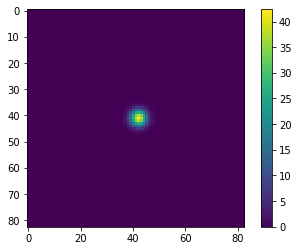

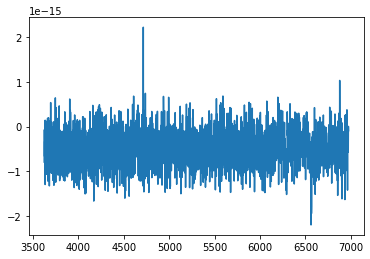

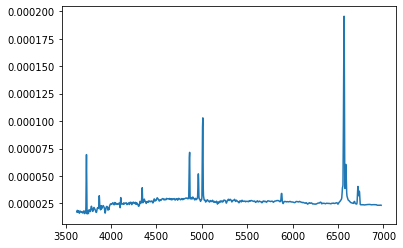

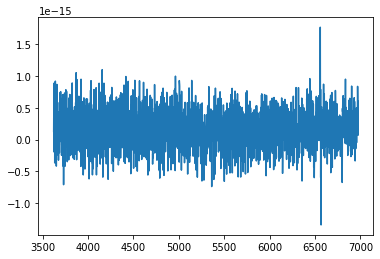

In [112]:
# Now check out what the AGN looks like at different positions
plt.clf()
plt.imshow(conv[1000,:,:])
plt.colorbar()
plt.show()

plt.plot(cut_manga_wave, conv[:,20,20])
plt.show()

plt.plot(cut_manga_wave, conv[:,coords[0][0], coords[0][1]])
plt.show()

plt.plot(cut_manga_wave, conv[:,coords[0][0], coords[0][1]-1])
plt.show()

In [3]:
agnx0 = pyfits.open('mcrx_205_agnx0.fits')
print(agnx0[0].header)

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                    8 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H FILETYPE= 'TRANSFER'           / File contains output from a radiative transfer DATATYPE= 'GRID    '           / Data is on a grid                              NOBJECT =                    2 / Number of objects contained in this snapshot   SFRCODE = 'SFRHIST '           / See HDU SFRHIST for SFR history calculation setNBODYCOD= 'GADGET  '           / See HDU GADGET for nbody code setup            L-INDEP = 'LAMBDA  '           / See HDU LAMBDA for SED wavelengths             OBJECT  = 'GALAXY  '           / This sn

In [8]:
view = 0
CAMERA0=agnx0[25+view]#25  
Ang=np.array([x[0]*10**(10) for x in agnx0[5].data])
#so I think this is in air wavelengths, we need to convert to vacuum                                                 
s = 10**4/Ang
n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.000159740894897 / (38.92568793293 - s**2)
Ang_vac = Ang*n
pixelscale=CAMERA0.header['CD1_1']
kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)
try:
    window=CAMERA0.data[:,int(mid_x-mid[3]):int(mid_x+mid[3]),int(mid_y-mid[3]):int(mid_y+mid[3])]
except TypeError:
    STOP

Ang = Ang_vac

from scipy.interpolate import griddata


#first take care of the spatial direction by convolving and rebinning                                                

out = window

sigma = 2.5/2.355                                                                                                   \

kernel_sigma_pix = (sigma*(kpc_arcmin.value/60))/pixelscale                                                         \

                                                                                                                    \

gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)                                                             \

#do i need to apply this at every wavelength?                                                                       \

#maybe I can use replicate to make a 3D kernel instead lol                                                          \

gaussian_3D_kernel = np.repeat(gaussian_2D_kernel.array[np.newaxis,:,:], np.shape(out)[0], axis=0)
gaussian_3D_kernel = gaussian_3D_kernel#/np.sum(gaussian_3D_kernel)                                                  
from scipy import signal

#Try remaking that first dimension to have some shape                                                                

delta = []
for p in range(len(Ang)-1):
    delta.append(Ang[p+1]-Ang[p])

Ang_step = np.median(delta)#this is the size of each step in Ang, which averages around 0.3-0.35AA                   
#sigma = 72 km s is the median resolution; v/c = delta lam / lam                                                     
#1.67AA                

#This is 3.5AA on average                                                                                            
sigma_pix = 0.001#1/Ang_step#3.5/Ang_step#gives the sigma of the convolution in pixels                               
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

'''What if we tried making sigma_pix a function of wavelength'''
'''Actually the way to do this is to first interpolate onto a new wavelength scale and                               
then to do the same width convolution'''
'''So things need to be finer sampled (linearly) starting from the longest wavelengths'''

'''Build a new array'''
new_Ang=[]
for p in range(10*len(Ang)):
if p==0:
    starting_lambda=Ang[0]
else:
    starting_lambda=starting_lambda+starting_lambda/2000
new_Ang.append(starting_lambda)
if starting_lambda > Ang[-1]:
    break
'''Now remap onto this new weird angstrom scale before you convolve :/'''
input_all_conv = np.reshape(out, (out.shape[0],out.shape[1]*out.shape[2]))
input_all_conv = input_all_conv.T

min_index=np.where(new_Ang==find_nearest(new_Ang,Ang[0])[0])[0][0]+1
max_index=np.where(new_Ang==find_nearest(new_Ang,Ang[-1])[0])[0][0]-1
new_Ang_wave=new_Ang[min_index:max_index-1]
int_func = interpolate.interp1d(Ang, input_all_conv)
int_flux = int_func(new_Ang_wave)
int_flux = int_flux.T

ready_conv = np.reshape(int_flux, (int_flux.shape[0], out.shape[1], out.shape[2]))



gauss_1 = Gaussian1DKernel(sigma_pix)
norm_1D = gauss_1.array/np.max(gauss_1.array)

xs = np.linspace(0, len(gauss_1.array)-1, len(gauss_1.array))
#So now we have a normalized kernel to multiply every dimension of gaussian_3D_kernel by                             
#new = gaussian_3D_kernel*norm_1D[:,np.newaxis,np.newaxis]                                                           
new_3D = np.zeros((len(gauss_1.array),np.shape(gaussian_3D_kernel)[1],np.shape(gaussian_3D_kernel)[1]))
for o in range(np.shape(gaussian_3D_kernel)[1]):
    for h in range(np.shape(gaussian_3D_kernel)[1]):
        new_3D[:,o,h] = norm_1D*gaussian_3D_kernel[0,o,h]#instead of norm_1D used to be gauss_1.array                



conv = signal.fftconvolve(ready_conv, new_3D, mode='same')#kernel was gaussian_3D_kernel                             
#conv = ready_conv                                                                                                   
zoom_factor = (pixelscale/(kpc_arcmin.value/60))/0.5


rebin = scipy.ndimage.zoom(conv, (1, zoom_factor, zoom_factor), order=0)

input_all = np.reshape(rebin, (rebin.shape[0],rebin.shape[1]*rebin.shape[2]))
input_all = input_all.T

min_index=np.where(manga_wave==find_nearest(manga_wave,new_Ang_wave[0])[0])[0][0]+1
max_index=np.where(manga_wave==find_nearest(manga_wave,new_Ang_wave[-1])[0])[0][0]-1
cut_manga_wave=manga_wave[min_index:max_index-1]
int_func = interpolate.interp1d(new_Ang_wave, input_all)
int_flux = int_func(cut_manga_wave)
int_flux = int_flux.T

back = np.reshape(int_flux, (int_flux.shape[0], rebin.shape[1], rebin.shape[2]))


#now you need to add typical noise to the spectrum                                                                   
typ_noise = np.load('average_S_N.npy')[min_index:max_index-1]


try:
    mask_rebin = np.ma.array(back, mask = np.tile(mid[5].mask, (np.shape(back)[0],1)))
except np.ma.core.MaskError:
    continue


'''Now do a hexagon mask'''
size_a=pixelscale/(kpc_arcmin.value/60)
arcs_totes = 1.5*2*half_light_radius*size_a
fiber = determine_fiber(arcs_totes, size_a)
size = np.shape(back)[1]

coords=map_to_coords(mask_rebin, size)
inside = mask_map(size,fiber[1], coords[0], coords[1], size_a)

mask_rebin_hex = np.ma.array(mask_rebin, mask = ~np.tile(inside, (back.shape[0],1)))
mask_rebin_hex_saved = mask_rebin_hex
mask_rebin_saved = mask_rebin

try:
    mask_r_band = np.ma.array(mid_r[4], mask = ~inside)
except np.ma.core.MaskError:
    continue
    
mask_g_band_2D = np.ma.array(mid[4], mask = ~inside)
mask_g_band_noise_2D = np.ma.array(mid[4]/mid[5], mask = ~inside)



coords_voronoi = xys(mask_g_band_2D, mask_g_band_noise_2D, inside, size)


normalized_noise = typ_noise/np.median(typ_noise)
#gaussian array                                                                                                     \

mu, sigma = 0 , 1

add_noise_array = np.zeros((len(cut_manga_wave),np.shape(mask_rebin_hex)[1],np.shape(mask_rebin_hex)[2]))
s_noise_array = np.zeros((len(cut_manga_wave),np.shape(mask_rebin_hex)[1],np.shape(mask_rebin_hex)[2]))
troubleshoot_noise = np.zeros((len(cut_manga_wave),np.shape(mask_rebin_hex)[1],np.shape(mask_rebin_hex)[2]))
        
for u in range(np.shape(mask_rebin_hex)[1]):
    for l in range(np.shape(mask_rebin_hex)[2]):
        s=np.random.normal(mu,sigma,len(normalized_noise))
        #now multiply it by the mid[4] value                                                                            
        troubleshoot_noise[:,u,l] = mid[5][u,l]
        s_noise_array[:,u,l] = ((mask_rebin_hex[:,u,l])/(mid[5][u,l]*normalized_noise))
        add_noise_array[:,u,l] = s*(mask_rebin_hex[:,u,l]/(mid[5][u,l]*normalized_noise))
        #normalized noise is average S/N with a max of 1                                                             
        #mid[5] is the g-band S/N at that spaxel                                                                     
add_noise_array = np.ma.array(add_noise_array, mask = np.tile(mid[5].mask, (add_noise_array.shape[0],1)))
s_noise_array = np.ma.array(s_noise_array, mask = np.tile(mid[5].mask, (s_noise_array.shape[0],1)))

output_vor, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(np.array(coords_voronoi[0]), np.array(coords_voronoi[1]), np.array(coords_voronoi[2]), np.array(coords_voronoi[3]), 10, plot=0, quiet=1, sn_func=sn_func)

if type(output_vor) == int:
    input_all = np.reshape(mask_rebin_hex_saved,(np.shape(mask_rebin_hex_saved)[0], np.shape(mask_rebin_hex_saved)[1]*np.shape(mask_rebin_hex_saved)[2]))
    input_all = input_all.T
    input_noise = np.reshape(s_noise_array,(np.shape(mask_rebin_hex_saved)[0], np.shape(mask_rebin_hex_saved)[1]*np.shape(mask_rebin_hex_saved)[2]))
    input_noise = input_noise.T
    
else:


    '''Now its time to figure out how to deal with the Voronoi bins'''
    '''We need to remap the xs and ys back onto 2D maps'''
    remapped =remap(output_vor, np.array(coords_voronoi[0]), np.array(coords_voronoi[1]), xNode, yNode, mask_rebin_hex,add_noise_array, np.array(coords_voronoi[2]), s_noise_array)
    cmap_here='plasma'
    plt.clf()
    fig=plt.figure()
    ax0=fig.add_subplot(331)
#this will be the spatial dimension                                                                                 \

    im0 = ax0.imshow(abs(out[int(len(Ang)/2),:,:]), norm=matplotlib.colors.LogNorm(), cmap=cmap_here)
    plt.colorbar(im0)
    ax0.set_title('Simulated Galaxy')
    ax0.set_yticklabels([])
    ax0.set_xticklabels([])

    ax1 = fig.add_subplot(313)
    ax1.plot(Ang, np.apply_over_axes(np.mean,out, (1,2))[:,0,0]+0.5, label='Simulated Spectrum', lw=0.5)
    ax1.plot(new_Ang_wave, np.apply_over_axes(np.mean,conv, (1,2))[:,0,0], label='Convolved', lw=0.5)
    mu, sigma = 0,1
#s=np.random.normal(mu,sigma,len(mask_rebin_hex[:,0,0]))                                                             

    ax1.plot(cut_manga_wave, np.apply_over_axes(np.mean,mask_rebin_hex+add_noise_array,(1,2))[:,0,0]-0.5, label='Con\
volved and Rebinned', lw=0.5)
    ax1.plot(cut_manga_wave, np.apply_over_axes(np.mean,add_noise_array,(1,2))[:,0,0], label='Noise', lw=0.5)
    #plt.ylim([-0.2,5])                                                                                              
    plt.xlim([3500,4500])
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Relative Flux')
    plt.legend(loc='upper center', ncol=4,framealpha=1, frameon=True)#, bbox_to_anchor=(1.2, 0.5))                   
    ax2 = fig.add_subplot(332)
    im2 = ax2.imshow(conv[int(len(new_Ang_wave)/2),:,:], norm=matplotlib.colors.LogNorm(), cmap=cmap_here)
    ax2.set_title('3D Convolved')
    plt.colorbar(im2)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])

    ax4 = fig.add_subplot(333)
    im4 = ax4.imshow(mask_rebin_saved[int(len(cut_manga_wave)/2),:,:], norm=matplotlib.colors.LogNorm(), cmap=cmap_here)
    plt.colorbar(im4)
    ax4.set_title('Rebinned and Masked by S/N')
    ax4.set_yticklabels([])
    ax4.set_xticklabels([])



    ax5 = fig.add_subplot(334)
    im5 = ax5.imshow(mask_rebin_hex_saved[int(len(cut_manga_wave)/2),:,:], cmap='plasma', norm=matplotlib.colors.LogNorm())
    plt.colorbar(im5)
    ax5.set_title('Hexagonal Footprint Masked')
    ax5.set_yticklabels([])
    ax5.set_xticklabels([])

    masked_noise = ma.masked_where(np.isnan(remapped[0][int(len(cut_manga_wave)/2),:,:]), remapped[1][int(len(cut_manga_wave)/2),:,:])
    masked_noise = ma.masked_where(masked_noise==0, masked_noise)
    ax6 = fig.add_subplot(335)
    im6 = ax6.imshow(masked_noise, cmap='RdBu', norm=matplotlib.colors.LogNorm())
    #ax6.scatter(35,35)                                                                                              
    #ax6.scatter(35,17)                                                                                              
    plt.colorbar(im6)
    ax6.set_title('Add Noise')
    #ax6.set_yticklabels([])                                                                                         
    #ax6.set_xticklabels([])                                                                                         

    vor_masked=ma.masked_where(remapped[4]==0, remapped[4])
    ax7 = fig.add_subplot(336)
    im7 = ax7.imshow(vor_masked, cmap='jet')
    plt.colorbar(im7)#, fraction=0.046, pad=0.04)                                                                    
    ax7.set_title('Voronoi Bins')
    ax7.set_yticklabels([])
    ax7.set_xticklabels([])
    plt.tight_layout()
    plt.savefig('maps/description_remapped_check_SCATTER_kin_correct_noise_conv_'+str(run)+'_'+str(myr)+'_'+str(view)+'.png', dpi=1000)

    '''find the spaxel of maximum brightness, this is the AGN light'''

    plt.clf()
    summed_specs = np.sum(out,axis=0)
    coords = np.argwhere(summed_specs.max() == summed_specs)
    #max_coord = np.where(summed_specs = np.max(summed_specs))                                                       
    print('max coords', coords)
    plt.plot(Ang, out[:,coords[0][0],coords[0][1]], label='Simulated Spectrum', lw=0.5)

    plt.savefig('brightest_spaxel_'+str(run)+'_'+str(myr)+'_'+str(view)+'.png', dpi=1000)

    input_all = np.array(remapped[6])



    input_noise = np.array(remapped[7])#was np.array()                                                               




print(np.shape(input_all))
print(np.shape(cut_manga_wave))


hdul = pyfits.HDUList()
hdul.append(pyfits.PrimaryHDU(data = input_all))
hdul.writeto('maps/small_cube_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits', clobber='True')





# Find a way to give the masked pixels the values of their starting ones'''                                         \

redist = redistribute_voronoi(output_vor, np.array(coords_voronoi[0]), np.array(coords_voronoi[1]), xNode, yNode, mask_rebin_hex,add_noise_array, np.array(coords_voronoi[2]), input_all, input_noise, input_all, input_noise, remapped[8])     \



kins=redist[0]#np.reshape(redist[0],(spectrum.shape[1],spectrum.shape[2]))                                          \

kins_err=redist[1]#np.reshape(redist[1],(spectrum.shape[1],spectrum.shape[2]))                                      \

sigma=redist[2]#np.reshape(redist[2],(spectrum.shape[1],spectrum.shape[2]))                                         \

sigma_err=redist[3]#np.reshape(redist[3],(spectrum.shape[1],spectrum.shape[2]))                                     \

print('what about the shape of the redist')
print(np.shape(kins))

hdul = pyfits.HDUList()
hdul.append(pyfits.PrimaryHDU(data = kins))
hdul.writeto('maps/small_cube_alt_shape_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits', clobber='True')




NameError: name 'cosmo' is not defined